In [48]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
import numpy as np
import scipy
from scipy.sparse import load_npz
import optuna
import numpy as np

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [11]:
X_train = load_npz('../vectors/tfidf_lemma/X_train_tfidf.npz')
y_train = np.load('../vectors/tfidf_lemma/y_train.npy')

X_test = load_npz('../vectors/tfidf_lemma/X_test_tfidf.npz')
y_test = np.load('../vectors/tfidf_lemma/y_test.npy')

In [12]:
X_train = scipy.sparse.csr_matrix.toarray(X_train)
X_test = scipy.sparse.csr_matrix.toarray(X_test)

In [13]:
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

In [14]:
model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='softmax'))  # 4 classes no exemplo

In [15]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
model.fit(X_train, y_train_onehot, epochs=10, batch_size=256, validation_split=0.2, verbose=2)

Epoch 1/10
21/21 - 1s - loss: 1.3525 - accuracy: 0.3619 - val_loss: 1.3252 - val_accuracy: 0.3529 - 967ms/epoch - 46ms/step
Epoch 2/10
21/21 - 0s - loss: 1.2649 - accuracy: 0.3853 - val_loss: 1.2690 - val_accuracy: 0.3948 - 307ms/epoch - 15ms/step
Epoch 3/10
21/21 - 0s - loss: 1.1369 - accuracy: 0.4773 - val_loss: 1.2025 - val_accuracy: 0.4505 - 304ms/epoch - 14ms/step
Epoch 4/10
21/21 - 0s - loss: 0.9560 - accuracy: 0.6334 - val_loss: 1.1766 - val_accuracy: 0.4657 - 251ms/epoch - 12ms/step
Epoch 5/10
21/21 - 0s - loss: 0.7551 - accuracy: 0.7527 - val_loss: 1.1918 - val_accuracy: 0.4840 - 234ms/epoch - 11ms/step
Epoch 6/10
21/21 - 0s - loss: 0.5751 - accuracy: 0.8337 - val_loss: 1.2684 - val_accuracy: 0.4688 - 292ms/epoch - 14ms/step
Epoch 7/10
21/21 - 0s - loss: 0.4322 - accuracy: 0.8912 - val_loss: 1.3617 - val_accuracy: 0.4710 - 313ms/epoch - 15ms/step
Epoch 8/10
21/21 - 0s - loss: 0.3186 - accuracy: 0.9312 - val_loss: 1.4614 - val_accuracy: 0.4642 - 296ms/epoch - 14ms/step
Epoch 9/

In [17]:
accuracy = model.evaluate(X_test, y_test_onehot)[1]
print(f'Acurácia do Modelo MLP: {accuracy}')

52/52 [==============================] - 0s 2ms/step - loss: 1.7770 - accuracy: 0.4567
Acurácia do Modelo MLP: 0.45670732855796814


52/52 [==============================] - 0s 1ms/step


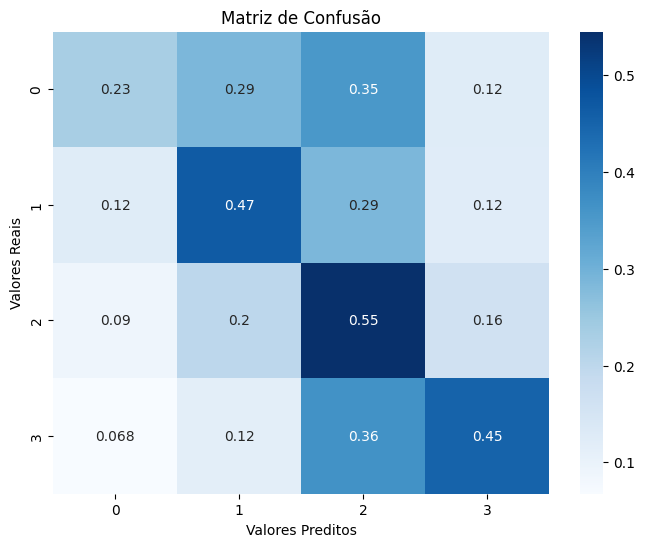

In [49]:


labels = ['0','1','2','3']

label_encoder = LabelEncoder()

y_pred_onehot = model.predict(X_test)

label_encoder.fit(labels)

y_pred = label_encoder.inverse_transform(y_pred_onehot.argmax(axis=1))

# Obter as verdadeiras classes no conjunto de teste
y_test_decoded = label_encoder.inverse_transform(y_test)

cm1 = confusion_matrix(y_test_decoded, y_pred)

cm1 = cm1.astype('float') / cm1.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão')
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.show()

In [44]:
def objective(trial):
    # Carregue seus dados aqui ou substitua por seus próprios dados
    # X_train, X_val, y_train, y_val = ...

    # Defina os hiperparâmetros que você deseja otimizar
    n_layers = trial.suggest_int('n_layers', 1, 4)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    units_per_layer = [trial.suggest_int(f'n_units_l{i}', 64, 128) for i in range(n_layers)]

    # Construa o modelo
    model = Sequential()
    for i in range(n_layers):
        model.add(Dense(units=units_per_layer[i], activation='relu'))

    model.add(Dense(units=4, activation='softmax'))  # Exemplo para classificação binária

    # Compile o modelo
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Treine o modelo
    model.fit(X_train, y_train_onehot, validation_data=(X_test, y_test_onehot), epochs=10, batch_size=256, verbose=0)

    # Avalie o modelo no conjunto de validação
    score = model.evaluate(X_test, y_test_onehot, verbose=0)

    # Retorne a métrica que você deseja otimizar (negativo porque o Optuna faz minimização)
    return -score[1]

In [45]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Obtenha os melhores hiperparâmetros
best_params = study.best_params
print("Melhores Hiperparâmetros:", best_params)

# Treine o modelo final com os melhores hiperparâmetros


[I 2023-12-16 17:32:00,026] A new study created in memory with name: no-name-1fa1ab1e-5692-4519-84b9-0444967fb264
C:\Users\felma\AppData\Local\Temp\ipykernel_192\3837679105.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2023-12-16 17:32:03,846] Trial 0 finished with value: -0.3658536672592163 and parameters: {'n_layers': 3, 'learning_rate': 4.922358644636233e-05, 'n_units_l0': 65, 'n_units_l1': 73, 'n_units_l2': 120}. Best is trial 0 with value: -0.3658536672592163.
[I 2023-12-16 17:32:07,221] Trial 1 finished with value: -0.4615853726863861 and parameters: {'n_layers': 1, 'learning_rate': 0.0005884843064503868, 'n_units_l0': 87}. Best is trial 0 with value: -0.3658536672592163.
[I 2023-12-16 17:32:11,348] Trial 2 finished with value: -0.4365853667259

Melhores Hiperparâmetros: {'n_layers': 2, 'learning_rate': 1.0084191982068626e-05, 'n_units_l0': 112, 'n_units_l1': 112}


In [46]:
final_model = Sequential()
for i in range(best_params['n_layers']):
    final_model.add(Dense(units=best_params[f'n_units_l{i}'], activation='relu'))

final_model.add(Dense(units=4, activation='softmax'))  # Exemplo para classificação binária
final_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
                    loss='binary_crossentropy', metrics=['accuracy'])

final_model.fit(X_train, y_train_onehot, epochs=10, batch_size=256, validation_data=(X_test, y_test_onehot))

Epoch 1/10


26/26 [==============================] - 1s 15ms/step - loss: 0.6914 - accuracy: 0.3274 - val_loss: 0.6910 - val_accuracy: 0.3280
Epoch 2/10
26/26 [==============================] - 0s 10ms/step - loss: 0.6905 - accuracy: 0.3404 - val_loss: 0.6901 - val_accuracy: 0.3402
Epoch 3/10
26/26 [==============================] - 0s 11ms/step - loss: 0.6895 - accuracy: 0.3503 - val_loss: 0.6891 - val_accuracy: 0.3433
Epoch 4/10
26/26 [==============================] - 0s 10ms/step - loss: 0.6885 - accuracy: 0.3561 - val_loss: 0.6881 - val_accuracy: 0.3457
Epoch 5/10
26/26 [==============================] - 0s 10ms/step - loss: 0.6875 - accuracy: 0.3573 - val_loss: 0.6871 - val_accuracy: 0.3506
Epoch 6/10
26/26 [==============================] - 0s 10ms/step - loss: 0.6863 - accuracy: 0.3623 - val_loss: 0.6859 - val_accuracy: 0.3543
Epoch 7/10
26/26 [==============================] - 0s 10ms/step - loss: 0.6851 - accuracy: 0.3642 - val_loss: 0.6847 - val_accuracy: 0.3549
Epoch 8/10
26/26 [======

52/52 [==============================] - 0s 1ms/step


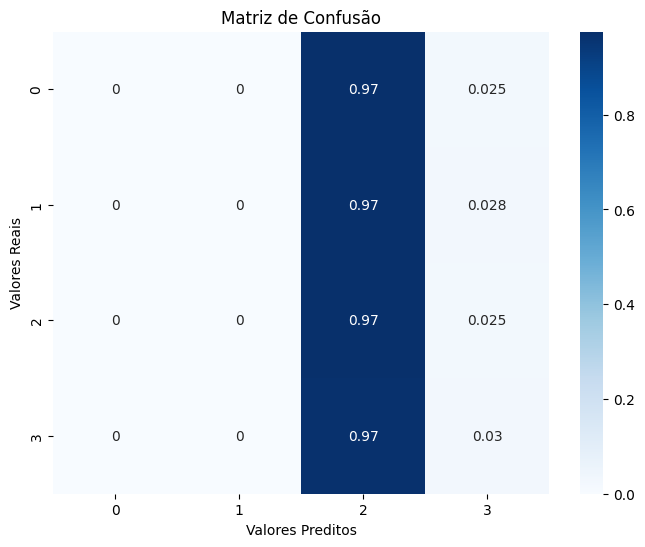

In [47]:


labels = ['0','1','2','3']

label_encoder = LabelEncoder()

y_pred_onehot = final_model.predict(X_test)

label_encoder.fit(labels)

y_pred = label_encoder.inverse_transform(y_pred_onehot.argmax(axis=1))

# Obter as verdadeiras classes no conjunto de teste
y_test_decoded = label_encoder.inverse_transform(y_test)

cm1 = confusion_matrix(y_test_decoded, y_pred)

cm1 = cm1.astype('float') / cm1.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão')
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.show()